<a href="https://colab.research.google.com/github/eovallemagallanes/Digital-Image-Processing/blob/main/lecture05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Thresholding

In [1]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, Checkbox

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku

In [4]:
def show(img, show_hist=True, show_by_channel=False, density=False):
    dims = img.shape
    if len(dims) < 2:
        print('Not an image')
        return
    if len(dims) == 2:
        # gray scale image, require aditional last channel
        #print('Expandig last dim')
        img = np.expand_dims(img, -1)
    
    # map to uint8
    img = np.array(img, dtype = np.uint8) 

    channels = img.shape[-1] # last dim is the channel
    if channels == 3:
        labels = ['Red', 'Green', 'Blue']
        colors = ['r', 'g', 'b']
    else:
        labels = ['Gray']
        colors = ['gray']
    if show_hist:
        if show_by_channel and channels == 3:
            fig, axs = plt.subplots(2, channels + 1,
                                       figsize=(12, 6))
            
            # Display original image.
            axs[0, 0].imshow(img)
            axs[0, 0].set_axis_off()
            axs[1, 0].set_axis_off()
            for i in range(channels):
                axs[0, i+1].imshow(img[..., i])
                axs[0, i+1].set_axis_off()

            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[1, i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color, density=density)
                axs[1, i+1].set_xlim(0, img[..., i].max())
                axs[1, i+1].set(xlabel=label)
                axs[1, i+1].set_yticks([])
        
            plt.show()
        else:
            # Display the image.
            fig, axs = plt.subplots(1, channels + 1,
                                        figsize=(12, 3))
        
            if channels == 3:
                axs[0].imshow(img)
            if channels == 1:
                axs[0].imshow(img[..., 0], cmap='gray')
            axs[0].set_axis_off()
        
            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color, density=density)
              
        
            plt.show()
    else:
        # Display the image.
        fig = plt.figure(figsize=(3, 3))
        if channels == 3:
            plt.imshow(img)
        if channels == 1:
            plt.imshow(img[..., 0], cmap='gray')
        plt.axis('off')

**Otsu Thresholding**


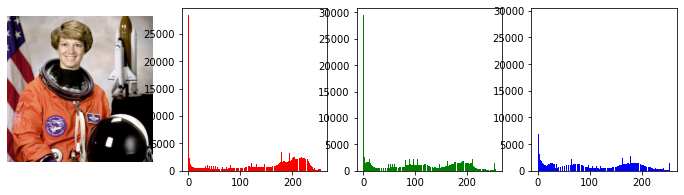

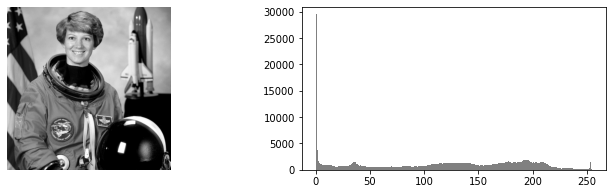

In [5]:
# working in range [0.0, 255.0]
#img = skimage.img_as_float(skid.chelsea())*255.0
img = skimage.img_as_float(skid.astronaut())*255.0
# read from file
#img = skimage.io.imread('desk.jpeg')*1.
show(img)

# convert to gray-scale image
gray_img = skic.rgb2gray(img)
show(gray_img)

In [6]:
def histogram(img):
    img = np.array(img, dtype = np.uint8).ravel()
    h = np.zeros((256))
    for pix in img:
        h[pix]+=1 
    
    return h/len(img)

def cum_histogram(img):
    h = histogram(img)
    h_cum = np.ones((256))
    h_cum[0] = h[0]
    for k in range(1,256):
        h_cum[k] = h[k] + h_cum[k-1]

    return h_cum

def mean(img):
    h = histogram(img)
    n = np.arange(0, 256)
    mu = np.sum(n*h)

    return mu

def var(img):
    h = histogram(img)
    mu = mean(img)
    n = np.arange(0, 256)
    v = np.sum(n**2 *h) - mu**2

    return v

In [34]:
def otsu(img):
    P = histogram(img)
    Pa = cum_histogram(img)
    muT = mean(img)
    n = np.arange(0, 256)
    mu_cum = np.array([np.sum(n[0:i]*P[0:i]) for i in n]) # one single computation for all mu
    
    varB = np.zeros(256)
    varW = np.ones(256)*10000

    # avoid both intensity limits, 0, 255
    for t in range(1, 255):
        w1 = Pa[t]
        w2 = 1 - w1
        mu1 = 0 if w1 == 0 else  mu_cum[t]/w1 # avoid zero division
        mu2 = (muT - w1*mu1)/w2 

        # get var for each class
        var1 = np.sum((n[1:t]-mu1)**2 * P[n[1:t]])/w1
        var2 = np.sum((n[t:255]-mu2)**2 * P[n[t:255]])/w2

        # variance between classes
        varB[t] = w1*w2*(mu1 - mu2)**2

        varW[t] = w1*var1 + w2*var2


    th1, th2 = np.argmax(varB), np.argmin(varW)

    return th1, th2



Otsu thresholds:  108 109


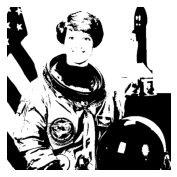

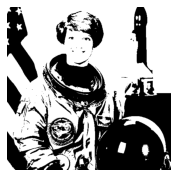

In [35]:
th1, th2 = otsu(gray_img)
print('Otsu thresholds: ', th1, th2)
img_th1 = 255*np.array(gray_img >= th1, dtype=int)
show(img_th1, False)

img_th2 = 255*np.array(gray_img >= th2, dtype=int)
show(img_th2, False)
